In [2]:
import pandas as pd
import numpy as np

eps = 10**-8

In [39]:
train = pd.read_csv("output/random_train0310.csv")
test = pd.read_csv("output/random_test0310.csv")
val = pd.read_csv("output/random_val0310.csv")

train = train[train.LoanStatus != "MISSING"]
test = test[test.LoanStatus != "MISSING"]
val = val[val.LoanStatus != "MISSING"]

print len(train.columns), "columns"
print train.dtypes

29 columns
BorrCity                         object
BorrState                        object
BorrZip                          object
CDC_City                         object
CDC_State                        object
CDC_Zip                          object
ThirdPartyLender_City            object
ThirdPartyLender_State           object
ApprovalDate                     object
ApprovalFiscalYear                int64
DeliveryMethod                   object
subpgmdesc                       object
TermInMonths                      int64
ProjectCounty                    object
ProjectState                     object
BusinessType                     object
LoanStatus                       object
ChargeOffDate                    object
GrossChargeOffAmount            float64
SP500_Yearly_Return             float64
CPI                             float64
Log_GrossApproval_Norm          float64
Log_HPI_Norm                    float64
ThirdPartyDollars_Norm          float64
TermMultipleYear             

In [4]:
m_train = float(len(train))
m_test = float(len(test))
m_val = float(len(val))
print m_train, m_test, m_val

43844.0 5481.0 5481.0


In [5]:
# Compute some statistics
print 'Train set:'
chargeoff_count = (train.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_train

print '\n', 'Test set:'
chargeoff_count = (test.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_test

print '\n', 'Validation set:'
chargeoff_count = (val.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_val

Train set:
Chargeoffs: 7124
Percentage of loans that defaulted: 0.16248517471

Test set:
Chargeoffs: 891
Percentage of loans that defaulted: 0.162561576355

Validation set:
Chargeoffs: 967
Percentage of loans that defaulted: 0.176427659186


In [50]:
# filtering for the columns you don't want to include for your model
c = train.columns.tolist()
dropped_columns = ['LoanStatus', 'ChargeOffDate', 'GrossChargeOffAmount', 'BorrZip', 'CDC_Zip', 'BorrCity',
                   'CDC_City', 'ThirdPartyLender_City', 'ProjectCounty', 'ApprovalDate']
for col in dropped_columns:
    c.remove(col)
print(len(c)), "covariates"
print c

19 covariates
['BorrState', 'CDC_State', 'ThirdPartyLender_State', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'ProjectState', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Log_GrossApproval_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics']


In [51]:
x_train = train[c]
x_test = test[c]
x_val = val[c]

y_train_logit = train['LoanStatus'].values == "CHGOFF"
y_test_logit = test['LoanStatus'].values == "CHGOFF"
y_val_logit = val['LoanStatus'].values == "CHGOFF"

print x_train.shape
print y_train_logit.shape
print x_train.dtypes

# hazard_target = train['ChargeOffDate']
# amount_target = train['GrossChargeOffAmount']

(43844, 19)
(43844,)
BorrState                        object
CDC_State                        object
ThirdPartyLender_State           object
ApprovalFiscalYear                int64
DeliveryMethod                   object
subpgmdesc                       object
TermInMonths                      int64
ProjectState                     object
BusinessType                     object
SP500_Yearly_Return             float64
CPI                             float64
Log_GrossApproval_Norm          float64
Log_HPI_Norm                    float64
ThirdPartyDollars_Norm          float64
TermMultipleYear                   bool
RepeatBorrower                    int64
BankStateneqBorrowerState          bool
ProjectStateneqBorrowerState       bool
2DigitNaics                      object
dtype: object


In [53]:
numerics = x_train.select_dtypes(include=[np.number,'bool'])
cats = x_train.drop(columns=numerics.columns)

uniques = np.unique(cats.values)

print "approx. number of covariate levels:", len(uniques)
print cats.dtypes

approx. number of covariate levels: 98
BorrState                 object
CDC_State                 object
ThirdPartyLender_State    object
DeliveryMethod            object
subpgmdesc                object
ProjectState              object
BusinessType              object
2DigitNaics               object
dtype: object


In [54]:
# print train.dtypes
# convert categorical variables to dummy variables
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_val = pd.get_dummies(x_val)

print x_train.shape

(43844, 272)


In [55]:
# to get consistent feature dimensions for both train and test dataset
def add_missing_columns(d1, d2):
    missing_cols_2 = (set(d1.columns) - set(d2.columns))
    missing_cols_1 = (set(d2.columns) - set(d1.columns))
    for c in missing_cols_2:
        d2[c] = 0
    for c in missing_cols_1:
        d1[c] = 0
    return d1, d2

print 'before fixing columns: '
print x_train.shape
print x_test.shape
print x_val.shape

x_train, x_test = add_missing_columns(x_train, x_test)
x_train, x_val = add_missing_columns(x_train, x_val)
x_test, x_val = add_missing_columns(x_test, x_val)
print 'after fixing columns: '
print x_train.shape
print x_test.shape
print x_val.shape

before fixing columns: 
(43844, 272)
(5481, 260)
(5481, 260)
after fixing columns: 
(43844, 274)
(5481, 274)
(5481, 274)


In [63]:
# fit to models 
# below is to fit to logit model

# y_train_logit = np.reshape(l, (len(l),))
from sklearn.linear_model import LogisticRegression
solver = 'liblinear'

lr = LogisticRegression(solver=solver, 
                        multi_class= 'ovr', 
                        C=5000.,
                        penalty = 'l2',
                        fit_intercept=True,
                        max_iter=200,
                        random_state=None,
                        tol = 10**-4
                       )
lr.fit(x_train, y_train_logit)

LogisticRegression(C=5000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [71]:
y_probs_test = lr.predict_proba(x_test)
y_probs_val = lr.predict_proba(x_val)
print y_probs_val[:5]

[[0.87638227 0.12361773]
 [0.86553068 0.13446932]
 [0.79262959 0.20737041]
 [0.06094669 0.93905331]
 [0.90174342 0.09825658]]


In [65]:
y_preds_val = y_probs_val[:,1] > 0.2
print y_preds_val[:5].reshape(5,1)
print "\n", "validation accuracy", np.sum(y_preds_val == y_val_logit, dtype=float) / m_val
print "false positive rate",  np.sum((y_val_logit == 0) * (y_preds_val == 1)) / (np.sum(y_val_logit == 0, dtype=float) + eps)
print "true positive rate", np.sum((y_val_logit == 1) * (y_preds_val == 1)) / (np.sum(y_val_logit == 1, dtype=float) + eps)

[[False]
 [False]
 [ True]
 [ True]
 [False]]

validation accuracy 0.6414887794198139
false positive rate 0.36442179884722103
true positive rate 0.669079627707662


In [74]:
import matplotlib.pyplot as plt
test_fprs, test_tprs, val_fprs, val_tprs  = [], [], [], []
step_size = 0.00001
for threshold in np.arange(0.001,1,step_size):
    y_preds_val = y_probs_val[:,1] > threshold
    num_pos = np.sum(y_preds_val == 1, dtype=float) + eps
    val_fprs.append(np.sum((y_val_logit == 0) * (y_preds_val == 1)) / (np.sum(y_val_logit == 0, dtype=float) + eps))
    val_tprs.append(np.sum((y_val_logit == 1) * (y_preds_val == 1)) / (np.sum(y_val_logit == 1, dtype=float) + eps))
    
    y_preds_test = y_probs_test[:,1] > threshold
    num_pos = np.sum(y_preds_test == 1, dtype=float) + eps
    test_fprs.append(np.sum((y_test_logit == 0) * (y_preds_test == 1)) / (np.sum(y_test_logit == 0, dtype=float) + eps))
    test_tprs.append(np.sum((y_test_logit == 1) * (y_preds_test == 1)) / (np.sum(y_test_logit == 1, dtype=float) + eps))
print fprs[:5]
print tprs[:5]

[0.9999999999977847, 0.9999999999977847, 0.9999999999977847, 0.9999999999977847, 0.9999999999977847]
[0.9999999999896587, 0.9999999999896587, 0.9999999999896587, 0.9999999999896587, 0.9999999999896587]


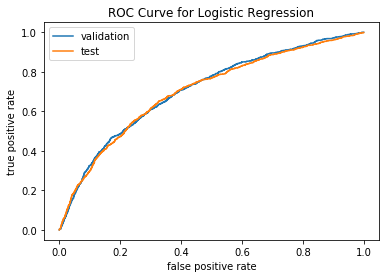

In [76]:
plt.title("ROC Curve for Logistic Regression")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")

valplt, = plt.plot(val_fprs,val_tprs,label='validation')
testplt, = plt.plot(test_fprs,test_tprs,label='test')
plt.legend(handles = [valplt, testplt])

plt.show()

In [62]:
x_prev = 0.
auc = 0
for x, y in zip(sorted(fprs), sorted(tprs)):
    auc += (x - x_prev)*y
    x_prev = x
print "area under curve: ", auc

area under curve:  0.24867137467906794


In [31]:
senses = np.array(tprs, dtype=float) + eps
specs = 1 - np.array(fprs, dtype=float) + eps
h_mean = 2. / (1 / senses + 1 / specs)
opt_index = np.argmax(h_mean)
opt_threshold = opt_index*step_size

print "best threshold: " , opt_threshold
print "highest sensitivity: ", tprs[opt_index]
print "highest specificity: ", 1 - fprs[opt_index]

best threshold:  0.24322000000000002
highest sensitivity:  0.6763185108513308
highest specificity:  0.6641559592386704


In [32]:
y_probs_train = lr.predict_proba(x_train)[:,1]
y_preds_train = y_probs_train > opt_threshold

y_probs_test = lr.predict_proba(x_test)[:,1]
y_preds_test = y_probs_test > opt_threshold
print y_probs_test[:5]
print y_preds_test[:5]

[0.07889901 0.14812234 0.1311184  0.10666061 0.89756055]
[False False False False  True]


In [33]:
# fit on training data to see if there is underfitting
print 'Training set'
print 'predicted proportion of defaults: ', np.sum(y_preds_train == 1) / m_train
print 'accuracy: ', np.sum(y_preds_train == y_train_logit) / m_train

# fit on test set to see if there is overfitting
print '\nTest set'
print 'predicted proportion of defaults: ', np.sum(y_preds_test == 1) / m_test
print 'accuracy: ', np.sum(y_preds_test == y_test_logit) / m_test

Training set
predicted proportion of defaults:  0.24190311103001552
accuracy:  0.8173068150716175

Test set
predicted proportion of defaults:  0.3638022258711914
accuracy:  0.682357234081372


In [16]:
# to discuss/redo cells below

In [17]:
# from sklearn import metrics

# print 'Training set'
# print metrics.classification_report(y_train_logit, y_pred_train)
# print '\nTest set'
# print metrics.classification_report(y_test_logit, y_pred_test)

In [18]:
# train = pd.read_csv("output/sorted_train0310.csv")
# test = pd.read_csv("output/sorted_test0310.csv")
# val = pd.read_csv("output/sorted_val0310.csv")

In [19]:
# ####### optional ##########
# # if import from sorted data - need to downsample train dataset to be more balanced
# # can call the following function multiple times for decreasing in log term
# # dropping PIF samples with 50% probability

# def drop_half(train):
#     print 'before drop: ', train.shape[0]
#     dropidx = []
#     for idx, val in train['LoanStatus'].iteritems():
#         if val != 'CHGOFF':
#             rand = np.random.rand()
#             if rand < 0.5:
#                 dropidx.append(idx)
#     train = train.drop(dropidx)
#     print 'after drop: ', train.shape[0]
#     return train
    
# train = drop_half(train)
# train = drop_half(train)
# # test = drop_half(test)

# chargeoff_count = (train['LoanStatus'] == "CHGOFF").sum()
# print 'Chargeoffs:', chargeoff_count
# print 'Percentage of loans that defaulted:', float(chargeoff_count)/len(train)

# chargeoff_count = (test['LoanStatus'] == "CHGOFF").sum()
# print 'Chargeoffs:', chargeoff_count
# print 'Percentage of loans that defaulted:', float(chargeoff_count)/len(test)